# Analysis of Lin Dyke model sensitivity to variations in storm temporal profile

## Description
Analysis of results of running 6hr duration, 1-in-100 year rainfall events through Hec-Ras model of Lin Dyke catchment. These include 15 observed profiles and FEH single peak profile.

## Overview of conclusions
1. The same proportion of urban and non-urban cells are affected by flooding in each rainfall scenario.   
2.	Within the 15 observed profiles there is considerable variation in the flooded area. There is a max difference between scenarios of 17% (with one being 7% lower than the FEH and other being 9% higher). 
3.	There is a relationship between the magnitude of the peak intensity and the total flooded area (and a much weaker relationship between the minute of the peak intensity and the flooded area). There is no relationship between the minute of peak intensity and the magnitude of peak intensity.
4.	There is also between scenario variation in the proportion of the flooded cells which fall within the different depth/velocity/hazard categories.
5.	Relationships seem to exist between the proportion of the flooded area in these different categories and the magnitude of the peak intensity/minute in which the peak occurs (but need to think further on how to capture this). 
6. More front loaded profiles have an earlier peak, and also generally a lower peak. 

In [17]:
import os
from pathlib import Path
from PIL import Image
# import geopandas as gpd
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from my_functions_idealisedprofiles import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define whether to filter out values <0.1
remove_little_values = True

model_directory = '../../../../FloodModelling/LinDykeModels/Model_IdealisedProfiles/'

region = '' #'' #'Garforth' #'Kippax'

# Water landcover classification
landcover_water, out_meta = open_and_clip( '../../../../FloodModelling/LandCoverData/LandCover_water_classification.tif')
landcover_water_flat = landcover_water.flatten()

### Plot the clusters

In [2]:
# fig,ax =plt.subplots(figsize=(50,20))
# img = Image.open("../../CreateSyntheticRainfallEvents/IdealisedProfiles/6hr_100yrRP/PostLossRemoval/Profile_plots.PNG")
# plt.axis('off')
# plt.imshow(img);

### Define the names of the method (shorter and longer versions)

In [19]:
methods =['6h_sp_c_0.5','6h_sp_fl_0.1', '6h_sp_fl_0.2', '6h_sp_fl_0.3', '6h_sp_fl_0.4',
          '6h_sp_bl_0.6','6h_sp_bl_0.7','6h_sp_bl_0.8','6h_sp_bl_0.9']
short_ids_by_loading_df = pd.DataFrame({'short_id':methods, 'loading':['C']+['F2']*2 + ['F1']*2 + ['B1']*2+ ['B2']*2 })

### Read in summary results from Processing-2.ipynb script

In [20]:
cluster_results= pd.read_csv("Data/{}allclusters_summary.csv".format(region))

In [21]:
colours_df  = cluster_results[['Cluster_num','colour']]

# Relationship between the number of flooded cells in urban and non-urban areas

27% of the catchment is classified as either urban or semi-urban.  

Changes to the extent, depth and velocity of flooding in these areas are the most important.  
Therefore, it is important to determine whether any of the rainfall scenarios result in a greater proportion of the flooding taking part in these urban areas.  

The plots below show:
* The relationship between the flooded area and the urban flooded area. There is a fairly consistent relationship across all the scenarios, with between 33 and 35% of the flooding being in urban areas. 
* The relationship between the percentage difference in flooded area between each scenario and the FEH single peak scenario in urban and non urban areas. This is also fairly consistent across the scenarios

In [22]:
cluster_results['%floodedarea_urban'] = round(cluster_results['UrbanFloodedArea']/cluster_results['TotalFloodedArea']*100,2)
cluster_results['%_of_area_flooded'] =(cluster_results['TotalFloodedArea']/29.589)*100
cluster_results['%_of_urban_area_flooded'] =(cluster_results['UrbanFloodedArea']/7.987)*100

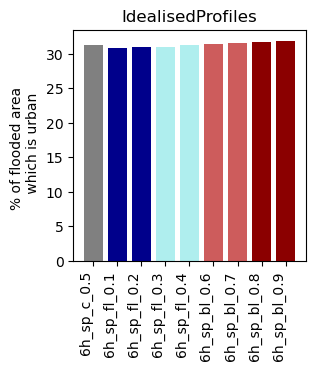

In [23]:
fig, axs = plt.subplots(figsize =(3,3))
cluster_results[['Cluster_num', '%_of_urban_area_flooded']]
axs.bar(cluster_results['Cluster_num'],cluster_results['%floodedarea_urban'], color = cluster_results['colour'] )
axs.set_ylabel("% of flooded area \n which is urban")
axs.xaxis.set_ticks(range(0,len(cluster_results['Cluster_num'])))
axs.set_xticklabels(cluster_results['Cluster_num'], rotation=90, ha='right')
plt.title("IdealisedProfiles");

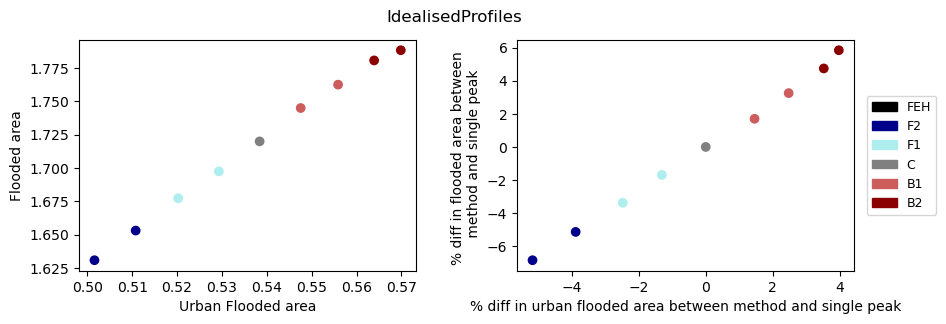

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,3))
# The urban flooded area as a percentage of the total area 
axs[0].scatter(cluster_results['UrbanFloodedArea'], cluster_results['TotalFloodedArea'], color = cluster_results['colour'])
axs[0].set_xlabel('Urban Flooded area')
axs[0].set_ylabel('Flooded area')
# (cluster_results['UrbanFloodedArea']/cluster_results['TotalFloodedArea'])*100
# The difference between the flooded area from a method and single peak 
axs[1].scatter(cluster_results['%Diff_FloodedArea_fromSP'], cluster_results['%Diff_UrbanFloodedArea_fromSP'],
              color = cluster_results['colour'])
axs[1].set_xlabel('% diff in urban flooded area between method and single peak')
axs[1].set_ylabel('% diff in flooded area between \n method and single peak');

colors = ['black','darkblue', 'paleturquoise', 'grey', 'indianred', 'darkred']
texts = ['FEH','F2','F1','C', 'B1', 'B2'] 
patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.14, 0.5), loc='center', ncol=1, prop={'size': 9} )

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
fig.suptitle("IdealisedProfiles");

# Relationship between the total flooded area & the rainfall scenario used
One difference that might be expected to arise from the use of different rainfall scenarios is a difference in the total area which is flooded.  

The plots below display the total flooded area generated by each of the rainfall scenarios, and the percentage difference between each scenario and the FEH single peak scenario.  
*  In the first row of plots, the scenarios are ordered by the minute at which the maximum rainfall intensity occurs, with the most front loaded profiles towards the left. 
*  In the second row, the scenarios are ordered by the maximum rainfall intensity, with the scenarios with the highest intensities on the left. 

This shows that there is variation in the total flooded area, with the extremes being one scenario having 9.4% more, and another having 7.2% less flooded area than the FEH single peak scenario. 

In [25]:
cluster_results['%Diff_FloodedArea_fromSP_formatted']=cluster_results['%Diff_FloodedArea_fromSP_formatted'].fillna('')
cluster_results['%Diff_UrbanFloodedArea_fromSP_formatted']=cluster_results['%Diff_UrbanFloodedArea_fromSP_formatted'].fillna('')

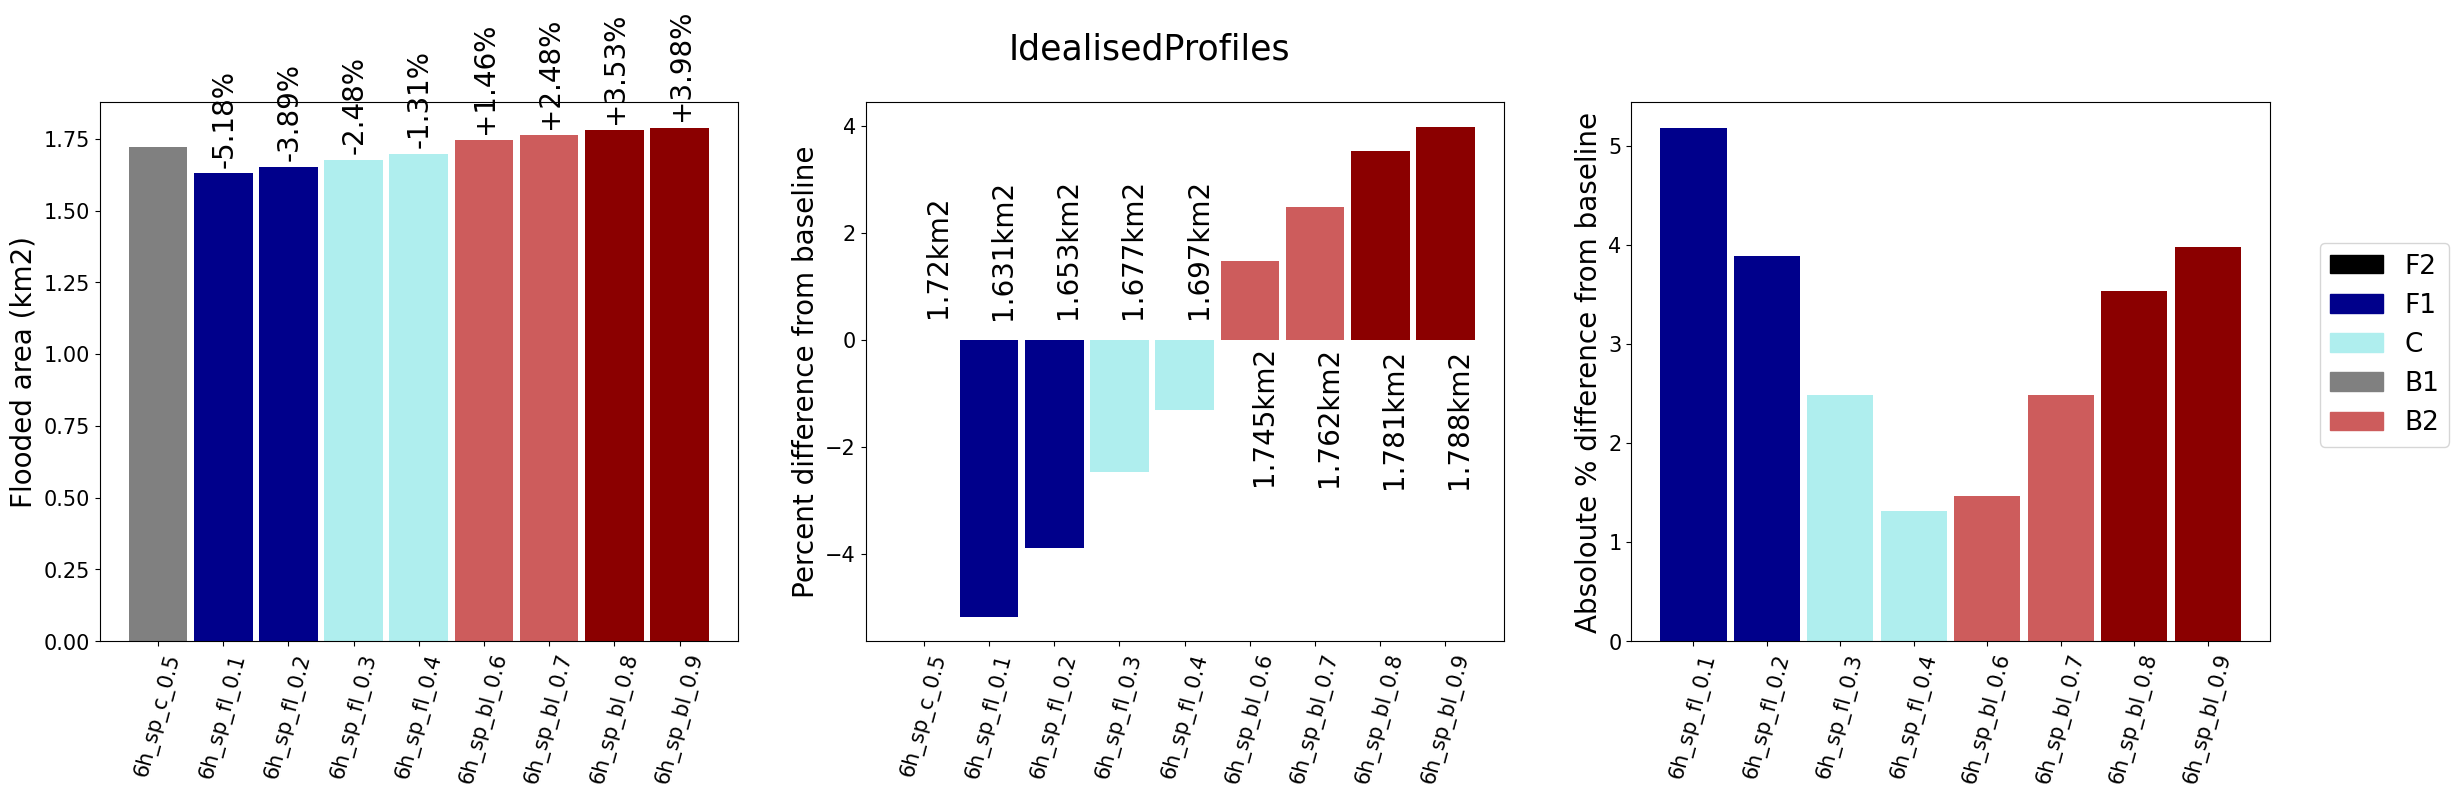

In [26]:
plot_totals(cluster_results, methods,  'IdealisedProfiles')

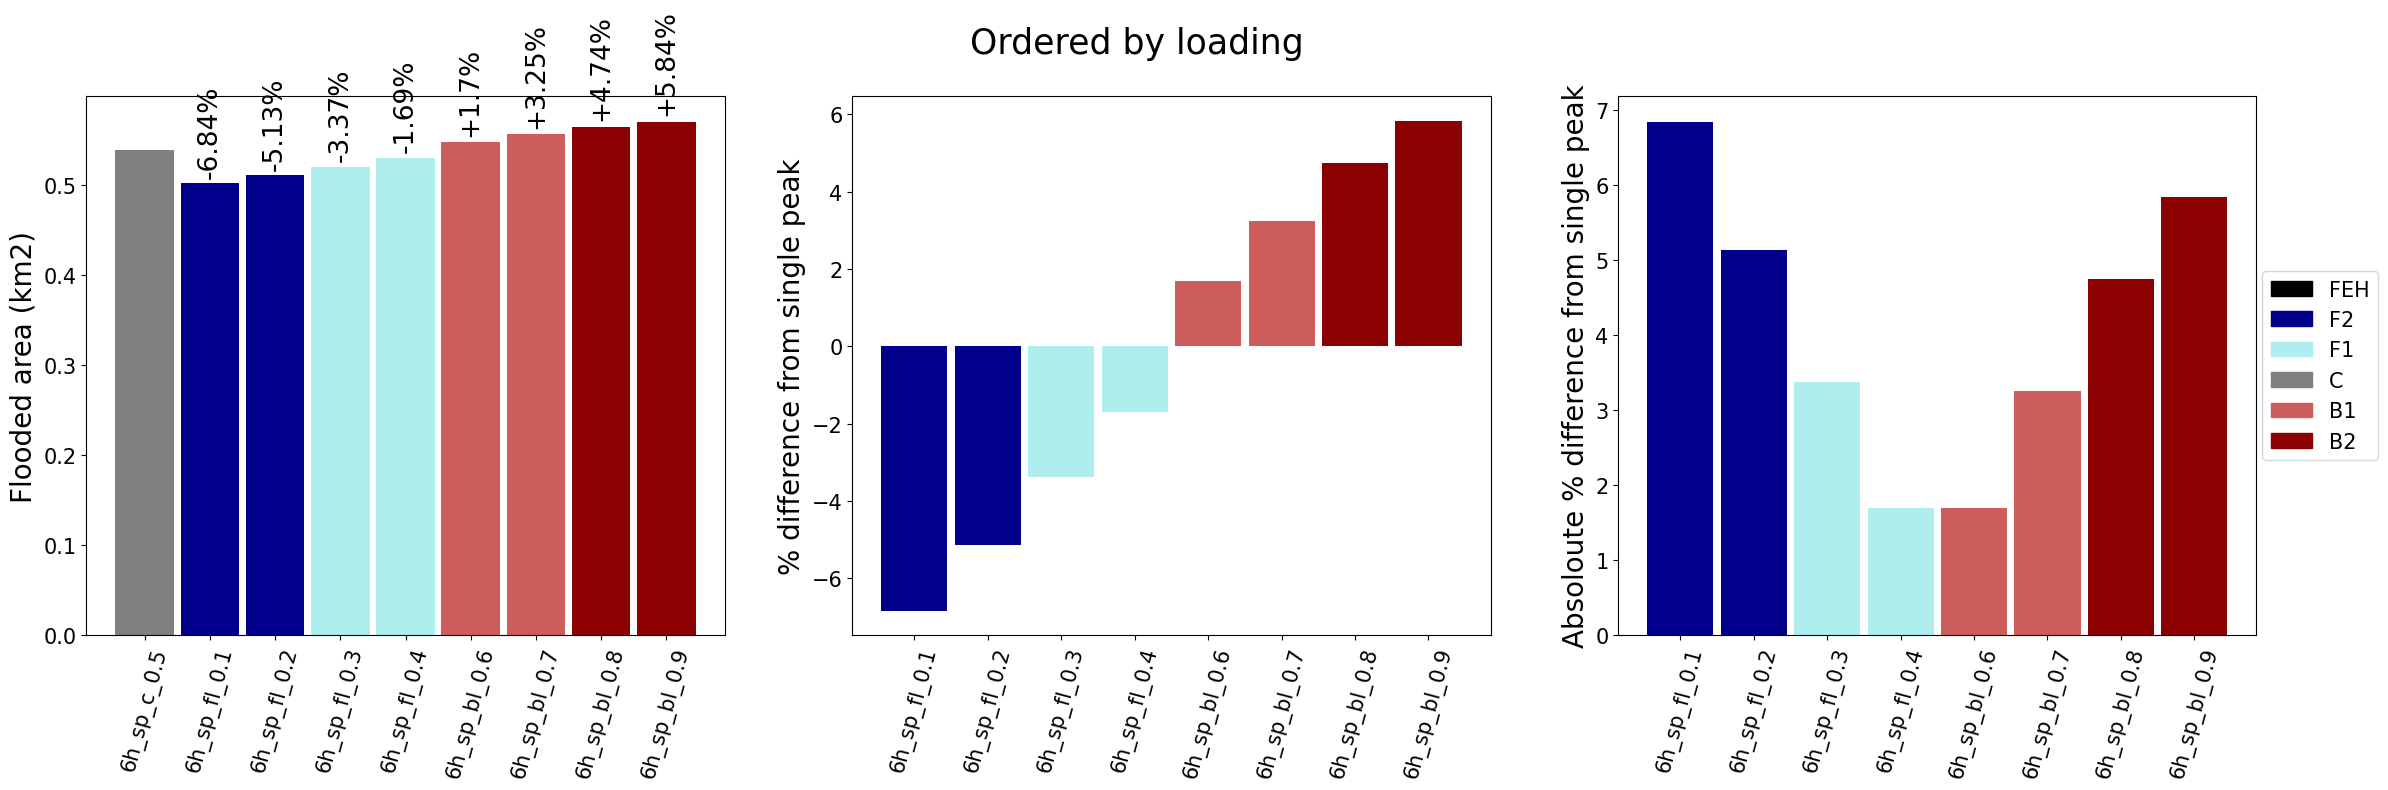

In [27]:
plot_totals_urban(cluster_results, methods, 'Ordered by loading')

### Plot the maximum peak intensity value, and the minute of max intensity against the flooded area

The relationship between the total flooded area and both the peak intensity and the minute of the peak intensity are also plotted for each scenario.

Additionally, the far left hand plot plots the relationship between the minute of peak intensity and the peak intensity. This verifies that there is no relationship between peak intensity and minute of peak intensity. 

This shows that there is a positive relationship between the total flooded area and the magnitude of the peak intensity, and a weaker positive relationship between the minute of the peak intensity and the total flooded area. 

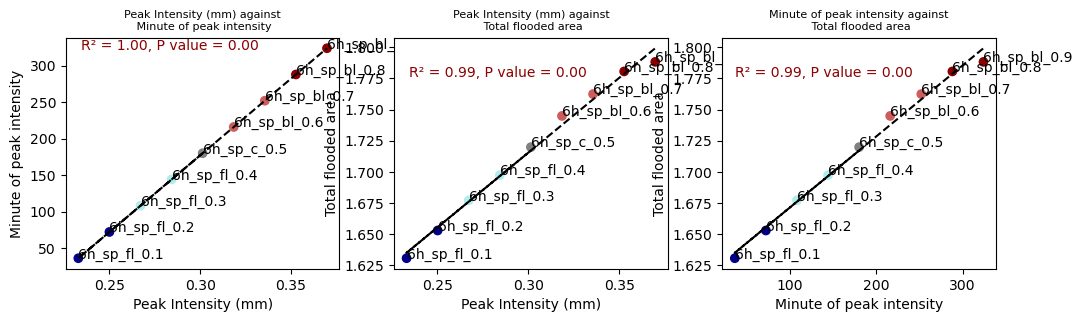

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (12,3))
scatter_plot_with_trend_line(axs[0], methods, cluster_results['MaxRainfallIntensity'], cluster_results['MaxRainfallIntensityMinute'], 'Peak Intensity (mm)' , 'Minute of peak intensity', cluster_results['colour'], add_r2 = True)
scatter_plot_with_trend_line(axs[1], methods, cluster_results['MaxRainfallIntensity'], cluster_results['TotalFloodedArea'], 'Peak Intensity (mm)' , 'Total flooded area', cluster_results['colour'], add_r2 = True)
scatter_plot_with_trend_line(axs[2], methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['TotalFloodedArea'], 'Minute of peak intensity' , 'Total flooded area',cluster_results['colour'], add_r2 = True)

In [ ]:
# fig, ax = plt.subplots(figsize = (4,3))
# scatter_plot_with_trend_line(ax, methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['TotalFloodedArea'], 'Minute of peak intensity' , 'Total flooded area',cluster_results['colour'], add_r2 = True)

# Relationship between flood severity & the rainfall scenario used

In addition to the difference which rainfall scenarios make to the total area which is flooded, it is also possible that the scenarios could influence the severity of the flooding in terms of the depth, velocity or hazard associated with the flooding.

In [29]:
velocity_props  =  reformat_counts_and_props(cluster_results, ['<=0.25m/s_propcells','0.25-0.5m/s_propcells', '0.5-2m/s_propcells', '>2m/s_propcells'], methods)        
velocity_props_urban  =  reformat_counts_and_props(cluster_results, ['<=0.25m/s_propcells_urban','0.25-0.5m/s_propcells_urban', '0.5-2m/s_propcells_urban', '>2m/s_propcells_urban'], methods)
velocity_counts  =  reformat_counts_and_props(cluster_results, ['<=0.25m/s_countcells','0.25-0.5m/s_countcells', '0.5-2m/s_countcells', '>2m/s_countcells'], methods)       
velocity_counts_urban  =  reformat_counts_and_props(cluster_results, ['<=0.25m/s_countcells_urban','0.25-0.5m/s_countcells_urban', '0.5-2m/s_countcells_urban', '>2m/s_countcells_urban'], methods)

depth_props  =  reformat_counts_and_props(cluster_results, ['<=0.3m_propcells','0.3-0.6m_propcells', '0.6-1.2m_propcells', '>1.2m_propcells'], methods)        
depth_props_urban  =  reformat_counts_and_props(cluster_results, ['<=0.3m_propcells_urban','0.3-0.6m_propcells_urban', '0.6-1.2m_propcells_urban', '>1.2m_propcells_urban'], methods)
depth_counts  =  reformat_counts_and_props(cluster_results, ['<=0.3m_countcells','0.3-0.6m_countcells', '0.6-1.2m_countcells', '>1.2m_countcells'], methods)        
depth_counts_urban  =  reformat_counts_and_props(cluster_results, ['<=0.3m_countcells_urban','0.3-0.6m_countcells_urban', '0.6-1.2m_countcells_urban', '>1.2m_countcells_urban'], methods)

hazard_counts =  reformat_counts_and_props(cluster_results, ['Low hazard_numcells','Moderate hazard_numcells', 'Significant hazard_numcells','Extreme hazard_numcells'], methods)
hazard_props =  reformat_counts_and_props(cluster_results, ['Low hazard_propcells','Moderate hazard_propcells', 'Significant hazard_propcells','Extreme hazard_propcells'], methods)
# hazard_catchange_counts = reformat_counts_and_props(cluster_results, [ 'Hazard_2CatsLower_countcells', 'Hazard_1CatsLower_countcells', 'Hazard_SameCat_countcells', 'Hazard_1CatsHigher_countcells','Hazard_2CatsHigher_countcells'], methods)
# hazard_catchange_props = reformat_counts_and_props(cluster_results, ['Hazard_2CatsLower_propcells', 'Hazard_1CatsLower_propcells', 'Hazard_SameCat_propcells', 'Hazard_1CatsHigher_propcells', 'Hazard_2CatsHigher_propcells'], methods)

### Boxplot summarising the number of cells with different depths/velocity values

#### Create a dataframe storing the value for each cell (for both depth and velocity)

In [ ]:
def produce_df_of_cell_by_cell_values(methods, landcover_water_flat):
    all_methods_df = pd.DataFrame()

    for method_num, short_id in enumerate(methods):
        # Filepath
        fp = model_directory + "{}/{} (Max).Resampled.Terrain.tif".format(short_id, '{}')
        # Dataframe where results for this method will be stored
        one_method_df = pd.DataFrame({"short_id" :methods[method_num], 'Water_class':landcover_water_flat})
        # Read raster, round to three decimal places
        for variable_name in ['Depth','Velocity']:
            raster = prepare_rainfall_scenario_raster(fp.format(variable_name), remove_little_values)[0]
            raster_rounded = np.around(raster, decimals=3)
            one_method_df[variable_name]=raster_rounded.flatten()
        one_method_df = one_method_df.dropna(subset=['Depth', 'Velocity'])

        # Join results for this method with results for all methods  
        all_methods_df = pd.concat([all_methods_df, one_method_df], axis =0)
        
    return all_methods_df    


In [30]:
depths_df = pd.DataFrame()
velocitys_df = pd.DataFrame()

for method_num, short_id in enumerate(['6h_sp_fl_0.1', "6h_sp_bl_0.9"]):
    # Filepath
    fp = model_directory + "{}/{} (Max).Resampled.Terrain.tif".format(short_id, '{}')
    # Dataframe where results for this method will be stored
    one_method_df = pd.DataFrame({"short_id" :methods[method_num], 'Water_class':landcover_water_flat})
    # Read raster, round to three decimal places
    for variable_name in ['Depth','Velocity']:
        raster = prepare_rainfall_scenario_raster(fp.format(variable_name), remove_little_values)[0]
        raster_rounded = np.around(raster, decimals=3)
        one_method_df[variable_name]=raster_rounded.flatten()
    #one_method_df = one_method_df.dropna(subset=['Depth', 'Velocity'])

    # Join results for this method with results for all methods  
    depths_df[short_id] = one_method_df['Depth']
    velocitys_df[short_id] = one_method_df['Velocity']

#### Check the number of cells flooded in one scenario but not the other 
(Think this was checking whether the two scenarios have the same cells flooded - but just some extras added for BL09 - don't think this is the case)

In [31]:
bl09_vals = depths_df.dropna(subset=['6h_sp_bl_0.9'])
cells_flooded_in_bl09_not_fl01 = bl09_vals[bl09_vals['6h_sp_fl_0.1'].isnull()]
fl01_vals = depths_df.dropna(subset=['6h_sp_fl_0.1'])
cells_flooded_in_fl01_not_bl09 = fl01_vals[fl01_vals['6h_sp_bl_0.9'].isnull()]

27667

In [ ]:
each_cells_value_inclnas = produce_df_of_cell_by_cell_values(methods, landcover_water_flat)
# each_cells_value_inclnas
# depths_df = pd.DataFrame()
# velocitys_df = pd.DataFrame()
# # Join results for this method with results for all methods  
# depths_df[short_id] = one_method_df['Depth']
# velocitys_df[short_id] = one_method_df['Velocity']
# depths_df= depths_df.dropna(subset=['6h_sp_bl_0.9'])
# depths_df
# extra_cells = depths_df[depths_df['6h_sp_fl_0.1'].isnull()]
len(extra_cells)

In [ ]:
extreme_methods_cells_values= each_cells_value.loc[each_cells_value['short_id'].isin(['6h_sp_bl_0.9', '6h_sp_fl_0.1'])]

extreme_methods_cells_values_notwater = extreme_methods_cells_values[extreme_methods_cells_values['Water_class']!=10]
extreme_methods_cells_values_over2 = extreme_methods_cells_values[extreme_methods_cells_values['Depth']>2]
extreme_methods_cells_values_under2 = extreme_methods_cells_values[extreme_methods_cells_values['Depth']<2]
extreme_methods_cells_values_under5 = extreme_methods_cells_values[extreme_methods_cells_values['Depth']<5]

extreme_methods_cells_values_under0_5 = extreme_methods_cells_values[extreme_methods_cells_values['Depth']<0.5]


In [ ]:
fl_01 = extreme_methods_cells_values[extreme_methods_cells_values['short_id']=='6h_sp_fl_0.1']
bl_09 = extreme_methods_cells_values[extreme_methods_cells_values['short_id']=='6h_sp_bl_0.9']

In [ ]:
depths= [0.1,0.2,0.3, 0.5, 1, 2, 5]
props_df =pd.DataFrame({'Depth':depths})
counts_df =pd.DataFrame({'Depth':depths})
for method in methods:
    this_method = each_cells_value[each_cells_value['short_id']==method]
    props=[]
    counts=[]
    for depth in depths:
        props.append(round(len(this_method[this_method['Depth']>depth])/len(this_method) *100,2))
        counts.append(len(this_method[this_method['Depth']>depth]))
    props_df[method] = props
    counts_df[method] = counts

In [ ]:
# counts_df[['Depth','6h_sp_fl_0.1','6h_sp_bl_0.9']]

In [ ]:
sns.histplot(data=pd.concat([bl_09,fl_01],axis=0), x='Depth', hue='short_id',stat='count',element = 'step', 
             fill =False,log_scale=False,bins=np.cumsum([0.1*1.15**i for i in np.arange (0.1,10.1,1)]), palette = ['darkblue','darkred'])

In [ ]:
extreme_methods_cells_values_under0_5 = extreme_methods_cells_values[extreme_methods_cells_values['Depth']<0.5]
fl_01 = extreme_methods_cells_values_under2[extreme_methods_cells_values_under2['short_id']=='6h_sp_fl_0.1']
bl_09 = extreme_methods_cells_values_under2[extreme_methods_cells_values_under2['short_id']=='6h_sp_bl_0.9']

variable_name='Depth'
fig,axs=plt.subplots(ncols=2,nrows=5, figsize = (18,18))
for num, bin_num in enumerate([5,10,20,30,40]):
    hist_bl09, bin_edges_bl09 = np.histogram(bl_09[variable_name], bins =bin_num)
    hist_fl01, bin_edges_fl01 = np.histogram(fl_01[variable_name], bins = bin_num)
    list_labels = []
    for i in range(0,len(bin_edges_bl09)-1):
        list_labels.append(str(round(bin_edges_bl09[i],2)) + '-'+ str(round(bin_edges_bl09[i+1],2))+'m')
    df = pd.DataFrame({'Bins':list_labels, 'BL09': hist_bl09, 'FL01': hist_fl01})
    df['%'] = (df['BL09'] - df['FL01']) / df['FL01'] * 100
    
    # Plot % difference between BL09 and FL01
    axs[num,0].bar(df['Bins'], df['%'])
    axs[num,0].tick_params(axis='x', rotation=45)
    axs[num,0].set_ylabel('% diff between BL09 and FL01')
    
    # Plot histogram
    sns.histplot(ax=axs[num,1],data=pd.concat([bl_09,fl_01],axis=0), x='Depth', hue='short_id',stat='count',element = 'step', 
             fill =False,log_scale=False,bins=bin_num, palette = ['darkblue','darkred'])

### Plot the proportion of the total flooded cells in various depth/velocity/hazard categories
To test whether any of the scenarios lead to more severe flooding outcomes (within the same flooded extent)

The plots below display the proportion of the total flooded area which is in each depth/velocity/hazard category, generated by each of the rainfall scenarios. 
*  In the first row of plots, the scenarios are ordered by the minute at which the maximum rainfall intensity occurs, with the most front loaded profiles towards the left. 
*  In the second row, the scenarios are ordered by the maximum rainfall intensity, with the scenarios with the highest intensities on the left. 

The plots ordered by loading seem to suggest there to be a relationship between the degree of front loading of the storm and the proportion of cells with a significant hazard rating. The scatter plots that follow allow further exploration of this.

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (20,4))
bar_plot_props(fig, axs[0],velocity_props, 'Velocity (m/s)',methods, colours_df, 'IdealisedProfiles')
bar_plot_props(fig,axs[1], depth_props, 'Depth (m)', methods, colours_df, 'IdealisedProfiles')
bar_plot_props(fig,axs[2], hazard_props, 'Hazard category', methods, colours_df, 'IdealisedProfiles')

#### Bar plot of the proportion of cells in each category across all scenarios in the same loading group
Currently this is calculated as the mean of the 3 proportions in each category  
Could alternatively be done by summing all the cells for the three categories together and then finding the proportions

In [ ]:
# fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (20,4))    
# bar_plot_props_by_loading_cat(fig, axs[0],velocity_props, 'Velocity (m/s)',methods, colours_df, 'Ordered by loading')
# bar_plot_props_by_loading_cat(fig,axs[1], depth_props, 'Depth (m)', methods, colours_df, 'Ordered by loading')
# bar_plot_props_by_loading_cat(fig,axs[2], hazard_props, 'Hazard category', methods, colours_df, 'Ordered by loading')    

### Plot the number of cells in various depth/velocity/hazard categories
To test whether any of the scenarios lead to more severe flooding outcomes (within the same flooded extent)

The plots below display the number of flooded cells which is in each depth/velocity/hazard category, generated by each of the rainfall scenarios. 
*  In the first row of plots, the scenarios are ordered by the minute at which the maximum rainfall intensity occurs, with the most front loaded profiles towards the left. 
*  In the second row, the scenarios are ordered by the maximum rainfall intensity, with the scenarios with the highest intensities on the left. 

The plots ordered by loading seem to suggest there to be a relationship between the degree of front loading of the storm and the proportion of cells with a significant hazard rating. The scatter plots that follow allow further exploration of this.

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (20,4))
bar_plot_counts(fig, axs[0],velocity_counts, 'Velocity (m/s)',methods, colours_df, 'Ordered by loading')
bar_plot_counts(fig,axs[1], depth_counts, 'Depth (m)', methods, colours_df, 'Ordered by loading')
bar_plot_counts(fig,axs[2], hazard_counts, 'Hazard category', methods, colours_df, 'Ordered by loading')

### Plot the maximum peak intensity value against the flooded area

The relationship between the proportion of flooded cells in various depth/velocity/hazard categories and both the peak intensity and the minute of the peak intensity are also plotted for each scenario.

This shows that there is a positive, significant relationship between proportion of cells in the shallowest depth categogy, and a negative, signficant relationship between the proportion of cells in the deepest depth category and the magnitude of the peak intensity (i.e. the higher the peak intensity, the greater the proportion of cells have shallower flooding, and the fewer the proportion of cells have deeper flooding). COUNTER INTUITIVE??

The relationship between the proportion of cells in the deepest depth category and the minute of peak intensity is also significant, with higher proportions found at later minutes. The relationship with the lowest depth category is not significant.

In [ ]:
# for x_var in ['MaxRainfallIntensity','MaxRainfallIntensityMinute' ]:
#     print(x_var)
#     for y_var in ['<=0.3m_propcells','0.3-0.6m_propcells','0.6-1.2m_propcells','>1.2m_propcells']:
#         m, b, r_value, p_value, std_err = stats.linregress(cluster_results[x_var], cluster_results[y_var])
#         print(y_var, 'r = ', round(r_value,2), ' p value = ', round(p_value,2))

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (10,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)
scatter_plot_with_trend_line(axs[0,0], methods, cluster_results['MaxRainfallIntensity'], cluster_results['<=0.3m_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nlowest depth cat',cluster_results['colour'],  add_r2 = True)
scatter_plot_with_trend_line(axs[0,1], methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['<=0.3m_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nlowest depth cat',cluster_results['colour'],  add_r2 = True)

scatter_plot_with_trend_line(axs[1,0], methods, cluster_results['MaxRainfallIntensity'], cluster_results['>1.2m_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nhighest depth cat', cluster_results['colour'], add_r2 = True)
scatter_plot_with_trend_line(axs[1,1], methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['>1.2m_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nhighest depth cat', cluster_results['colour'], add_r2 = True)

fig.suptitle("Relationship between depth category and maximum rainfall intensity value and timing");

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (10,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.6)
scatter_plot_with_trend_line(axs[0,0], methods, cluster_results['MaxRainfallIntensity'], cluster_results['<=0.25m/s_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nlowest velocity cat', cluster_results['colour'], add_r2 = True)
scatter_plot_with_trend_line(axs[0,1], methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['<=0.25m/s_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nlowest velocity cat', cluster_results['colour'], add_r2 = True)

scatter_plot_with_trend_line(axs[1,0], methods, cluster_results['MaxRainfallIntensity'], cluster_results['0.5-2m/s_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nhighest velocity cat',cluster_results['colour'],  add_r2 = True)
scatter_plot_with_trend_line(axs[1,1], methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['0.5-2m/s_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nhighest velocity cat',cluster_results['colour'],  add_r2 = True)
fig.suptitle("Relationship between velocity category and maximum rainfall intensity value and timing");

### Relationship between hazard and maximum rainfall intensity value and timing

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (10,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.55)
scatter_plot_with_trend_line(axs[0,0], methods, cluster_results['MaxRainfallIntensity'], cluster_results['Low hazard_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nlowest hazard cat',cluster_results['colour'],  add_r2 = True)
scatter_plot_with_trend_line(axs[0,1], methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['Low hazard_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nlowest hazard cat',cluster_results['colour'],  add_r2 = True)

scatter_plot_with_trend_line(axs[1,0], methods, cluster_results['MaxRainfallIntensity'], cluster_results['Extreme hazard_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nhighest hazard cat', cluster_results['colour'], add_r2 = True)
scatter_plot_with_trend_line(axs[1,1], methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['Extreme hazard_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nhighest hazard cat', cluster_results['colour'], add_r2 = True)

fig.suptitle("Relationship between hazard and maximum rainfall intensity value and timing");

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (10,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.55)
scatter_plot_with_trend_line(axs[0,0], methods, cluster_results['MaxRainfallIntensity'], cluster_results['Significant hazard_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nlowest hazard cat',cluster_results['colour'],  add_r2 = True)
scatter_plot_with_trend_line(axs[0,1], methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['Significant hazard_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nlowest hazard cat',cluster_results['colour'],  add_r2 = True)

scatter_plot_with_trend_line(axs[1,0], methods, cluster_results['MaxRainfallIntensity'], cluster_results['Moderate hazard_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nhighest hazard cat', cluster_results['colour'], add_r2 = True)
scatter_plot_with_trend_line(axs[1,1], methods, cluster_results['MaxRainfallIntensityMinute'], cluster_results['Moderate hazard_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nhighest hazard cat', cluster_results['colour'], add_r2 = True)

fig.suptitle("Relationship between hazard and maximum rainfall intensity value and timing");

## Method leading to deepest/fastest flooding in each cell

This plot shows the number of cells for each method which have flooding which is deeper or faster than in any of the other methods.

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (20,7))  
plot_worst_case_bars(axs[0], cluster_results, methods, 'WorstCaseDepth_ncells')
plot_worst_case_bars(axs[1], cluster_results, methods,'WorstCaseVelocity_ncells')    

# Hydrographs from different points in catchment
Within Hec-Ras profile line are constructed at several points in the catchment (based on Megan's report; check logic on this). See below. 
<!-- At each of these points -->

In [ ]:
fig,ax =plt.subplots(figsize=(10,5))
img = Image.open("../profilelines.PNG")
plt.axis('off')
plt.imshow(img);

In [ ]:
columns_obs = ['Time', '6h_sp_c_0.5','6h_sp_fl_0.1', '6h_sp_fl_0.2', '6h_sp_fl_0.3', '6h_sp_fl_0.4',
          '6h_sp_bl_0.6','6h_sp_bl_0.7','6h_sp_bl_0.8','6h_sp_bl_0.9']

### Find the maximum values and the time at which these maximum values are recorded

In [ ]:
flow_timeseries = pd.read_csv(model_directory + "ProfileLines/{}/Flow_timeseries.csv".format('SheffieldBeck'))[columns_obs]

# Create lists to store the maximum values and the times at which they occur
peak_times = []
max_vals = []
mins_peak_from_start = []
# Loop through each column and add a max value to the lists (can delete bit for NaNs once all data is fixed)
for number, column in enumerate(flow_timeseries.columns[1:]):
    max_row = flow_timeseries[flow_timeseries[column] == flow_timeseries[column].max()]
    if len(max_row) == 0:
        peak_times.append(np.nan)
        max_vals.append(np.nan)
        mins_peak_from_start.append(np.nan)
    else:
        peak_time = pd.to_datetime(max_row['Time'])[max_row['Time'].index[0]]
        mins_peak_from_start_this_profile = (peak_time - pd.to_datetime(flow_timeseries['Time'][0])).total_seconds()/60
        peak_times.append(peak_time)
        mins_peak_from_start.append(mins_peak_from_start_this_profile)
        max_vals.append(max_row[column][max_row[column].index[0]])

# Remove NANs (for now)
peak_times = [x for x in peak_times if str(x) != 'nan']        

## Flow
### Table of time to peak flow and the magnitude of peak flow for each profile
For Kipax Beck:  
There is a maximum difference between scenarios in peak flow intensity of 3.1 cumecs (so the largest peak flow is 93% higher than the smallest peak flow).    
There is a time difference of 280 minutes between arrivals of peak flows (so the an 174% change in the timing of the peak arrival). 

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (14,3), sharey=True)
for axs_numb, profile_line in enumerate(['KippaxBeck', 'SheffieldBeck', 'LinDyke']):
    flow_timeseries = pd.read_csv(model_directory + "ProfileLines/{}/Flow_timeseries.csv".format(profile_line))[columns_obs]
    for number, column in enumerate(flow_timeseries.columns[1:]):
        axs[axs_numb].plot(flow_timeseries[column], color = cluster_results['colour'][number])
        axs[axs_numb].set_title(profile_line)
        axs[axs_numb].set_xlabel('Minute')
        axs[axs_numb].set_ylabel('Flow (cumecs)')
# Legend
colors = ['black','darkblue', 'paleturquoise', 'grey', 'indianred', 'darkred']
texts = ['FEH','F2','F1','C', 'B1', 'B2'] 
patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.14, 0.5), loc='center', ncol=1, prop={'size': 9} )   ;

In [ ]:
df = pd.DataFrame({'profile':flow_timeseries.columns[1:], 'Time to peak flow (mins)':mins_peak_from_start,
             'Peak flow intensity (cumecs)':max_vals})
df = df.dropna()
df.reset_index(inplace=True, drop=True)
df.sort_values(by='Time to peak flow (mins)')

In [ ]:
def get_change(current, previous):
    if current == previous:
        return 0
    try:
        return round((abs(current - previous) / previous) * 100.0,1)
    except ZeroDivisionError:
        return float('inf')

In [ ]:
print(get_change(df['Peak flow intensity (cumecs)'].min(),df['Peak flow intensity (cumecs)'].max()))
print(get_change(df['Time to peak flow (mins)'].min(),df['Time to peak flow (mins)'].max()))
print(df['Time to peak flow (mins)'].max() - df['Time to peak flow (mins)'].min())

### Depth (these are actaully for a point not profile line, so don't make sense entirely)
Moving downstream (from Kippax Beck -> Sheffield Beck -> Lin Dyke): 

* The peak flow reduces (suggesting in journey downstream some water is lost i.e. to ponding or storage somewhere (this water will later be released) [altho from SB to LD at the end of the period the..]
* The time to peak increases (i.e. the peak occurs later in the event) as it takes longer for the water to travel downstream

More front loaded profiles have an earlier peak, and also generally a lower peak. 

<!-- If storage areas are filled up earlier then this would cause flow to peak higher and earlier -->

To do: Create table of the time of the peak flow and calculate % difference in peak flow between different profiles


In [ ]:
# fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (14,3), sharey=True)
# for axs_numb, profile_line in enumerate(['KippaxBeck', 'SheffieldBeck', 'LinDyke']):
#     depth_timeseries = pd.read_csv(model_directory + "ProfileLines/{}/Depth_Timeseries.csv".format(profile_line))[columns_obs]
#     for number, column in enumerate(depth_timeseries.columns[1:]):
#         axs[axs_numb].plot(depth_timeseries[column], color = cluster_results['colour'][number])
#         axs[axs_numb].set_title(profile_line)
# # Legend
# colors = ['black','darkblue', 'paleturquoise', 'grey', 'indianred', 'darkred']
# texts = ['FEH','F2','F1','C', 'B1', 'B2'] 
# patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
# plt.legend(handles=patches, bbox_to_anchor=(1.14, 0.5), loc='center', ncol=1, prop={'size': 9} )   ;

### Velocity

In [ ]:
# fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (14,3), sharey=True)
# for axs_numb, profile_line in enumerate(['KippaxBeck', 'SheffieldBeck', 'LinDyke']):
#     velocity_timeseries = pd.read_csv(model_directory + "ProfileLines/{}/Velocity_Timeseries.csv".format(profile_line))[columns_obs]
#     for number, column in enumerate(velocity_timeseries.columns[1:]):
#         axs[axs_numb].plot(velocity_timeseries[column], color = cluster_results['colour'][number])
# # Legend
# colors = ['black','darkblue', 'paleturquoise', 'grey', 'indianred', 'darkred']
# texts = ['FEH','F2','F1','C', 'B1', 'B2'] 
# patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
# plt.legend(handles=patches, bbox_to_anchor=(1.14, 0.5), loc='center', ncol=1, prop={'size': 9} )   ; 

### 

### Individual plot for each scenario containing values for each profile line 

In [ ]:
# colors_downstream = ['red', 'darkorange', 'gold']
# fig, axs = plt.subplots(nrows=4, ncols=4, figsize = (14,7), sharex=True, sharey=True)
# col_num =0
# for i in range(4):
#     for j in range(4):
#         column = flow_timeseries.columns[1:][col_num]
#         col_num+= 1
#         # Plot line for each profile line location
#         for axs_numb, profile_line in enumerate(['KippaxBeck', 'SheffieldBeck', 'LinDyke']):
#             flow_timeseries = pd.read_csv(model_directory + "ProfileLines/{}/Flow_Timeseries.csv".format(profile_line))[columns_obs]
#             axs[i,j].plot(flow_timeseries[column], color = colors_downstream[axs_numb])
#             axs[i,j].set_title(column)

In [ ]:
# Set up figure
f = folium.Figure(width=500, height=500)

# Create base map - location figures were from clat, clon, but wanted to create map before loop
mapa = folium.Map(location=[53.768306874761016, -1.3756056884868098],zoom_start=12).add_to(f)
folium.TileLayer(
    tiles = 'https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/{z}/{y}/{x}',
    attr="No Base Map",
    name="No Base Map",
    show=True
).add_to(mapa)

# Catchment boundary
catchment_boundary_feature_group = FeatureGroup(name='Catchment boundary')
catchment_boundary_feature_group.add_child(folium.GeoJson(data=catchment_gdf["geometry"], style_function=lambda x, 
                                     fillColor='#00000000', color='Black': { "fillColor": '#00000000',"color": 'Black',}))

# Add landcover data
landcover_fps = ['../../../../FloodModelling/LandCoverData/LandCover_clipped.tif',
                '../../../../FloodModelling/LandCoverData/LandCover_water_classification.tif',
                 '../../../../FloodModelling/LinDykeModels/Model_IdealisedProfiles/6h_sp_bl_0.9/Depth (Max)_morethan.5.Resampled.Terrain.tif',
                '../../../../FloodModelling/LinDykeModels/Model_IdealisedProfiles/6h_sp_bl_0.9/Depth (Max)_morethan1.Resampled.Terrain.tif',
                '../../../../FloodModelling/LinDykeModels/Model_IdealisedProfiles/6h_sp_bl_0.9/Depth (Max)_morethan2.Resampled.Terrain.tif']
names = [ 'landcover','Classified', 'Flooding_.5', 'Flooding_1', 'Flooding_2']
for number, landcover_fp in enumerate(landcover_fps):
    xarray_dataarray = prep_for_folium_plotting(landcover_fp)
    # Get coordinates needed in plotting
    clat, clon = xarray_dataarray.y.values.mean(), xarray_dataarray.x.values.mean()
    mlat, mlon = xarray_dataarray.y.values.min(), xarray_dataarray.x.values.min()
    xlat, xlon = xarray_dataarray.y.values.max(), xarray_dataarray.x.values.max()
    # Apply colormap
    data  = ma.masked_invalid(xarray_dataarray.values)
    if landcover_fp == fp.format('Depth'):
        colored_data = colorize(data.data, cmap = mpl.cm.Blues)
    elif landcover_fp == '../../../../FloodModelling/LandCoverData/LandCover_clipped.tif':
        colored_data = colorize(data.data, cmap=cmap)        
    else:
        colored_data = colorize(data.data, cmap=cmap_classified)
    
    # Add to map
    feature_group1 = FeatureGroup(name=names[number])
    feature_group1.add_child(folium.raster_layers.ImageOverlay(colored_data,
                              [[mlat, mlon], [xlat, xlon]],
                              opacity=0.8,interactive=True, popup=names[number]))
    mapa.add_child(feature_group1)

# Add layers to map
mapa.add_child(catchment_boundary_feature_group)
mapa.add_child(LayerControl("topright", collapsed = False))
display(mapa)